In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import json
from coref import COREF_ROOT
import coref.run_manager as rm

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import lets_plot as lp
lp.LetsPlot.setup_html()

In [ ]:
expts_root = Path(COREF_ROOT) / 'experiments'
outputs_root = Path(...) # TODO: set this!
def get_last_output(cfg_path, expts_root=expts_root, outputs_root=outputs_root):
    parent_dir = Path(rm.get_run_dir_parent(cfg_path, outputs_root, expts_root))
    dirs = [d for d in os.listdir(parent_dir)  if os.path.isdir(parent_dir / d)]
    success_dir = [d for d in dirs if 'done.out' in os.listdir(parent_dir / d)]
    if not success_dir:
        print(f"Error: no success in {cfg_path}")
        raise FileNotFoundError(f'No successful runs in {parent_dir}')
    max_run = max(int(d) for d in dirs)
    max_success = max(int(d) for d in success_dir)
    if max_run != max_success:
        print(f'Warning: latest run {max_run} of {cfg_path} is not successful. Falling back to {max_success}')
    return parent_dir / str(max_success)
        

In [4]:
def get_output_dir_from_cfg(cfg_path):
    cfg, meta_kwargs = rm.load_cfg(cfg_path)
    if '_output_dir' in meta_kwargs:
        return meta_kwargs['_output_dir']
    elif '_output_root' in meta_kwargs:
        return get_last_output(cfg_path, outputs_root=meta_kwargs['_output_root'])
    else:
        return get_last_output(cfg_path)

In [5]:
def attach_d(rows, d):
    return [
        {**row, **d} for row in rows
    ]

# Hessians

In [6]:
def read_attr_metrics(output_dir):
    with open(Path(output_dir) / 'attr_metrics.json') as f:
        metrics = json.load(f)
    return metrics
def read_name_metrics(output_dir):
    with open(Path(output_dir) / 'name_metrics.json') as f:
        metrics = json.load(f)
    return metrics

In [ ]:
all_attr_metrics = []
all_name_metrics = []
for model in ['tulu', 'llama']:
    for uniform_scale in [False, True]:
        for interpolating_factor in [0., 0.5, 1.]:
            eval_hessian_cfg = expts_root / f'point_hessians/paper/eval_{model}_scale_{uniform_scale}_interpolating_{interpolating_factor}.yaml'
            output_dir = get_output_dir_from_cfg(eval_hessian_cfg)
            try:
                attr_metrics = read_attr_metrics(output_dir)
                all_attr_metrics.extend(attach_d(
                    read_attr_metrics(output_dir),
                    {'name': f'eval_{model}_scale_{uniform_scale}_interpolating_{interpolating_factor}'}
                ))
                name_metrics = read_attr_metrics(output_dir)
                all_name_metrics.extend(attach_d(
                    read_name_metrics(output_dir),
                    {'name': f'eval_{model}_scale_{uniform_scale}_interpolating_{interpolating_factor}'}
                ))
            except:
                print(f'Error: {output_dir}')

In [8]:

for model in ['tulu', 'llama']:
    random_cfg = expts_root / f'point_hessians/paper/random_{model}.yaml'
    output_dir = get_output_dir_from_cfg(random_cfg)
    try:
        attr_metrics = read_attr_metrics(output_dir)
        all_attr_metrics.extend(attach_d(
            read_attr_metrics(output_dir),
            {'name': f'random_{model}'}
        ))
        name_metrics = read_attr_metrics(output_dir)
        all_name_metrics.extend(attach_d(
            read_name_metrics(output_dir),
            {'name': f'random_{model}'}
        ))
    except:
        print(f'Error: {output_dir}')

In [9]:
all_dims = [1, 3, 15, 50, 250, 1000, 5120]
for model in ['llama', 'tulu']:
    for d_subspace in all_dims:
        cfg_path = expts_root / f'das/{model}_{d_subspace}.yaml'
        output_dir = Path(get_output_dir_from_cfg(cfg_path))
        with open(output_dir/'eval'/'name_metrics.json') as f:
            name_metrics = json.load(f)
        all_name_metrics.extend(attach_d(
            name_metrics,
            {'dim': d_subspace, 'name': f'das_{model}'}
        ))
        with open(output_dir/'eval'/'attr_metrics.json') as f:
            attr_metrics = json.load(f)
        all_attr_metrics.extend(attach_d(
            attr_metrics,
            {'dim': d_subspace, 'name': f'das_{model}'}
        ))

In [10]:
vb_name_metrics = []
vb_attr_metrics = []
for model in ['llama', 'tulu']:
    cfg_path = expts_root / f'point_hessians/paper/baseline_{model}.yaml'
    output_dir = get_output_dir_from_cfg(cfg_path) / '3_vecs'
    
    vb_name_metrics.extend(attach_d(
        read_name_metrics(output_dir),
        {'model': model}
    ))
    vb_attr_metrics.extend(attach_d(
        read_attr_metrics(output_dir),
        {'model': model}
    ))
        

In [11]:

def plot_hess_metrics(metrics, model, ax, title):
    df = pd.DataFrame(metrics)
    plots_to_show = [
        f'eval_{model}_scale_False_interpolating_0.5',
        f'random_{model}',
        f'das_{model}'
    ]
    df = df[df['name'].isin(plots_to_show)]
    
    df.name = df.name.map(lambda x: {f'eval_{model}_scale_False_interpolating_0.5': 'Hessian', f'random_{model}': 'Random', f'das_{model}': 'DAS'}[x])
    df = df.rename(columns={'name': 'Method', 'worst_acc': 'Min Accuracy', 'switch': 'Switch'})

    sns.lineplot(
        df,
        y='Min Accuracy',
        x='dim',
        style='Switch',
        hue='Method',
        ax=ax
    )
    ax.semilogx()
    
    ax.set_title(title)
    
    # vector baseline
    baseline = {
        'Name': vb_name_metrics,
        'Attribute': vb_attr_metrics
    }[title]
    
    for linestyle, switch in zip(['-', '--', ':'], ['0-1', '0-2', '1-2']):
        xd = pd.DataFrame(baseline).pivot(index='model', columns='switch', values='worst_acc').loc[model, switch]
        ax.axhline(y=xd, color='hotpink', linestyle=linestyle)
    

In [12]:
from matplotlib.lines import Line2D

In [23]:
def plot_both_hess_metrics(model):
    fig, axs = plt.subplots(1, 2, figsize=(9, 2.2))
    plot_hess_metrics(all_name_metrics, model, axs[0], 'Name')
    axs[0].get_legend().remove()
    plot_hess_metrics(all_attr_metrics, model, axs[1], 'Attribute')
    handles, labels = axs[1].get_legend_handles_labels()
    new_handle = Line2D([0], [0], label='Skyline', color='hotpink')
    new_label = 'Skyline'
    new_handles = handles[:4] + [new_handle] + handles[4:]
    axs[1].legend(ncol=2, handles=new_handles, loc='upper left', bbox_to_anchor=(1.01, 1))
    fig.tight_layout()
    

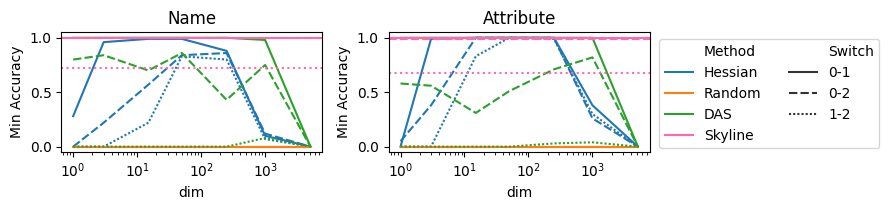

In [24]:
plot_both_hess_metrics('llama')

plt.savefig('figures/llama_hessian_dim.pdf', bbox_inches="tight")


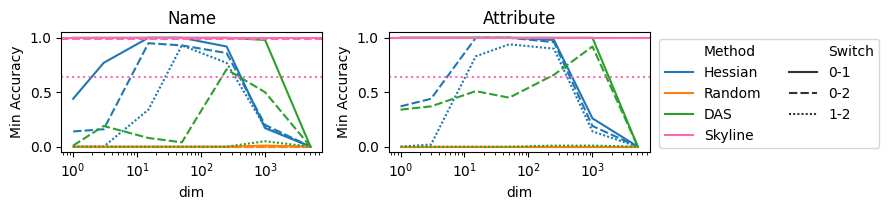

In [25]:
plot_both_hess_metrics('tulu')
plt.savefig('figures/tulu_hessian_dim.pdf', bbox_inches="tight")

In [18]:

def plot_hess_ablation_metrics(metrics, model, ax, title):
    df = pd.DataFrame(metrics)
    plots_to_show = [
        f'eval_{model}_scale_False_interpolating_0.5',
        f'eval_{model}_scale_True_interpolating_0.5',
        f'eval_{model}_scale_False_interpolating_0.0',
        f'eval_{model}_scale_False_interpolating_1.0',
    ]

    df = df[df['name'].isin(plots_to_show) & (df['switch'] == '1-2')]
    
    df.name = df.name.map(lambda x: {
        f'eval_{model}_scale_False_interpolating_0.5': 'Scale = True, Initial point = 0.5',
        f'eval_{model}_scale_True_interpolating_0.5': 'Scale = False, Initial point = 0.5',
        f'eval_{model}_scale_False_interpolating_0.0': 'Scale = True, Initial point = 0.0',
        f'eval_{model}_scale_False_interpolating_1.0': 'Scale = True, Initial point = 1.0',
    }[x])
    df = df.rename(columns={'name': 'Method', 'worst_acc': 'Min Accuracy', 'switch': 'Switch'})

    sns.lineplot(
        df,
        y='Min Accuracy',
        x='dim',
        hue='Method',
        ax=ax
    )
    ax.semilogx()
def plot_both_hess_ablations_metrics(model):
    fig, axs = plt.subplots(1, 2, figsize=(9, 3))
    plot_hess_ablation_metrics(all_name_metrics, model, axs[0], 'Name')
    axs[0].get_legend().remove()
    plot_hess_ablation_metrics(all_attr_metrics, model, axs[1], 'Attribute')
    axs[1].legend(loc='upper left', bbox_to_anchor=(0.4, 0.3))
    fig.tight_layout()
    

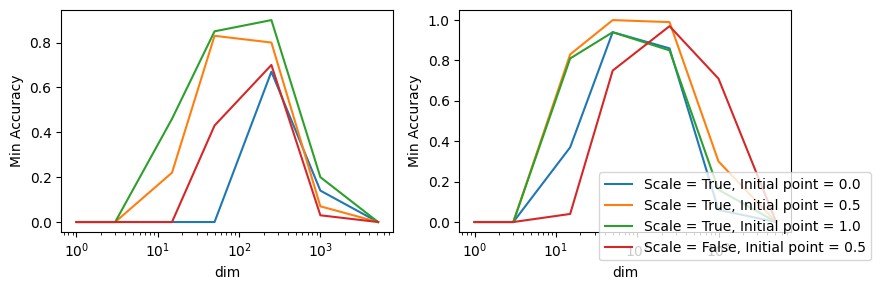

In [19]:
plot_both_hess_ablations_metrics('llama')
plt.savefig('figures/llama_hessian_dim_ablations.pdf', bbox_inches="tight")

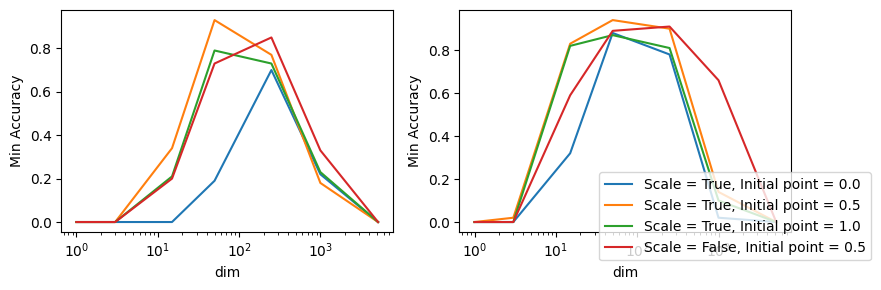

In [20]:
plot_both_hess_ablations_metrics('tulu')
plt.savefig('figures/tulu_hessian_dim_ablations.pdf', bbox_inches="tight")

## Qualitative

In [13]:
import torch

In [ ]:
plot_data = {}
for model in ['tulu', 'llama']:
    uniform_scale = False
    interpolating_factor = '0.5'
    eval_hessian_cfg = expts_root / f'point_hessians/paper/eval_{model}_scale_{uniform_scale}_interpolating_{interpolating_factor}.yaml'
    output_dir = Path(get_output_dir_from_cfg(eval_hessian_cfg))
    try:
        plot_data[model] = {
            'serial': torch.load(output_dir / 'serial_u2.pt'),
            'parallel': torch.load(output_dir / 'parallel_u2.pt')
        }
    except Exception as e:
        print(f'Error: {output_dir}')
        print(e)
                

In [15]:
def plot_layer(plot_data, ax, layer=15):
    all_data, context_str = plot_data
    sns.heatmap(
        all_data[layer],
        annot=False,
        square=True,
        xticklabels=context_str,
        yticklabels=context_str,
        cmap='rocket',
        ax=ax,        
    )

def plot_model(model):
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    plot_layer(plot_data[model]['serial'], axs[0])
    plot_layer(plot_data[model]['parallel'], axs[1])
    fig.tight_layout()
    

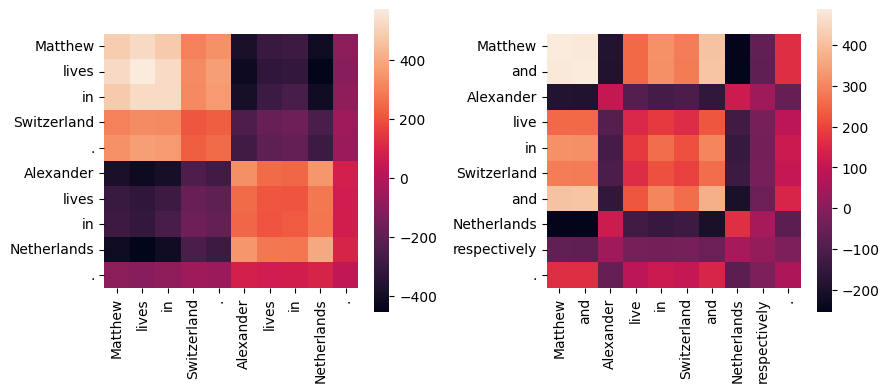

In [16]:
plot_model('tulu')
plt.savefig('figures/tulu_hessian_qualitative.pdf', bbox_inches="tight")


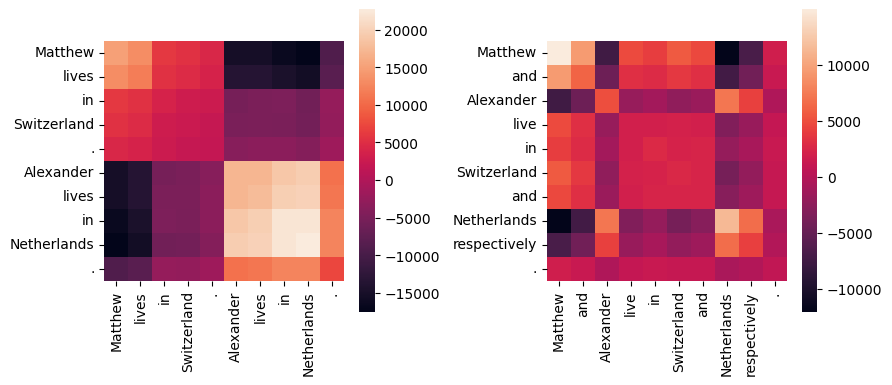

In [17]:
plot_model('llama')
plt.savefig('figures/llama_hessian_qualitative.pdf', bbox_inches="tight")


## Single example qualitative

In [9]:
import torch

In [21]:

plot_data = {}
for model in ['tulu',]:
    plot_data[model] = {
        'serial': torch.load(f'cache/{model}_series.pt'),
        'parallel': torch.load(f'cache/{model}_parallel.pt'),
        'cis': torch.load(f'cache/{model}_cis.pt'),
        'trans': torch.load(f'cache/{model}_trans.pt'),
        'triple': torch.load(f'cache/{model}_triple.pt'),
    }
                

In [25]:
def truncate_str(ls):
    return [
        s if len(s) < 8 else s[:4] + '.'
        for s in ls
    ]
        

In [26]:
def plot_layer(plot_data, ax, layer=15):
    all_data, context_str = plot_data
    sns.heatmap(
        all_data[layer],
        annot=False,
        square=True,
        xticklabels=truncate_str(context_str),
        yticklabels=truncate_str(context_str),
        cmap='rocket',
        ax=ax,        
    )


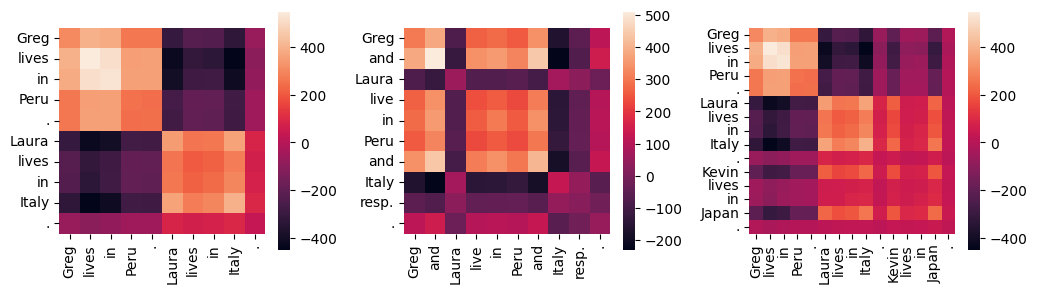

In [27]:

def plot_model(model):
    fig, axs = plt.subplots(1, 3, figsize=(10.5, 3))
    plot_layer(plot_data[model]['serial'], axs[0])
    plot_layer(plot_data[model]['parallel'], axs[1])
    plot_layer(plot_data[model]['triple'], axs[2])
    fig.tight_layout()
    
plot_model('tulu')
plt.savefig('figures/tulu_hessian_qualitative.pdf', bbox_inches="tight")

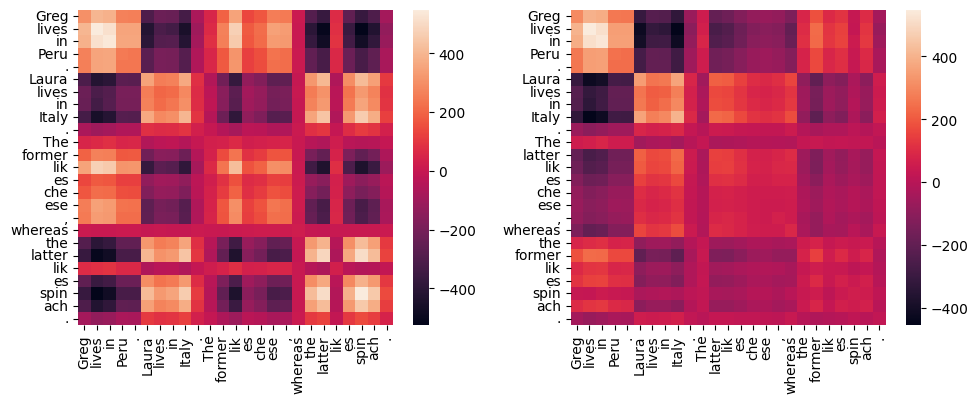

In [19]:

def plot_model(model):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    plot_layer(plot_data[model]['cis'], axs[0])
    plot_layer(plot_data[model]['trans'], axs[1])
    fig.tight_layout()
plot_model('tulu')
plt.savefig('figures/tulu_hessian_qualitative_coref.pdf', bbox_inches="tight")

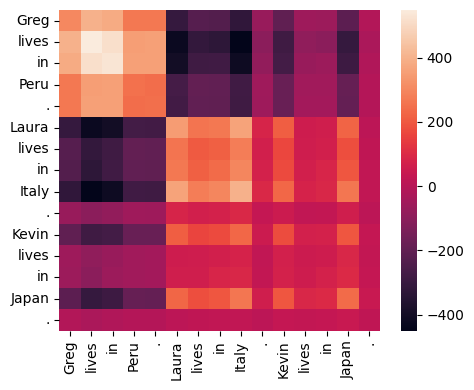

In [20]:

def plot_model(model):
    fig, axs = plt.subplots(1, 1, figsize=(5, 4))
    plot_layer(plot_data[model]['triple'], axs)
    fig.tight_layout()
plot_model('tulu')
plt.savefig('figures/tulu_hessian_qualitative_triple.pdf', bbox_inches="tight")

## DAS

In [9]:
from exults.plot_utils import read_jsonl

In [ ]:
all_dims = [1, 3, 15, 50, 250, 1000, 5120]
all_test_accs = []
for model in ['llama', 'tulu']:
    for d_subspace in all_dims:
        cfg_path = expts_root / f'das/{model}_{d_subspace}.yaml'
        try:
            output_dir = Path(get_output_dir_from_cfg(cfg_path))
            print(output_dir)
            all_test_accs.extend([
                {
                    'model': model,
                    'd_subspace': d_subspace,
                    'test_acc': test_acc,
                    'epoch': epoch,
                    'category': 'name'
                }
                for epoch, test_acc in enumerate(read_jsonl(output_dir/'logs/name_subspace/test_accs.jsonl'))
            ])
            all_test_accs.extend([
                {
                    'model': model,
                    'd_subspace': d_subspace,
                    'test_acc': test_acc,
                    'epoch': epoch,
                    'category': 'attr'
                }
                for epoch, test_acc in enumerate(read_jsonl(output_dir/'logs/attr_subspace/test_accs.jsonl'))
            ])
        except FileNotFoundError:
            print(f'Error with {cfg_path}')

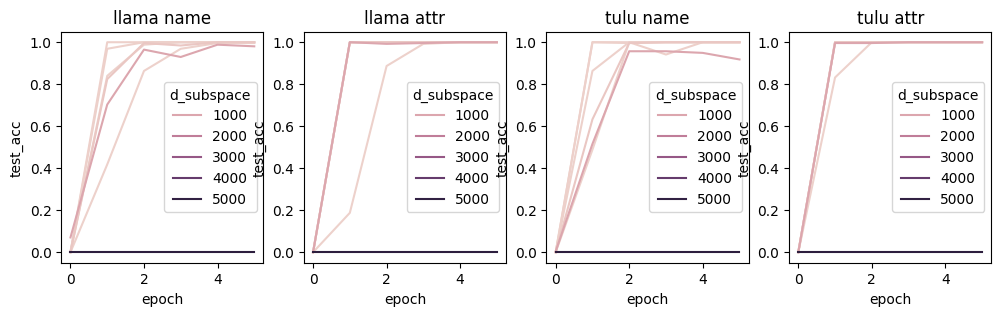

In [50]:
def plot_test_accs(model, category, ax):
    df = pd.DataFrame(all_test_accs)
    df = df[(df.model == model) & (df.category == category)]
    sns.lineplot(df, x='epoch', y='test_acc', hue='d_subspace', ax=ax)
    ax.set_title(f'{model} {category}')

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
idx = [ (model, category)
    for model in ['llama', 'tulu']
    for category in ['name', 'attr']
]
for (model, category), ax in zip(idx, axs.flatten()):
    plot_test_accs(model, category, ax)
    
        



# Domain Probes

In [21]:
def get_probe_output_dir(dataset, model, use_class_conditioned):
    cfg_path = expts_root / f'probes/eval_domain/{dataset}_{model}_use_class_{use_class_conditioned}_sweep.yaml'
    output_dir = get_last_output(cfg_path)
    return output_dir
def get_probe_save_dir(dataset, model, use_class_conditioned):
    cfg_path = expts_root / f'probes/eval_domain/{dataset}_{model}_use_class_{use_class_conditioned}_sweep.yaml'
    cfg, meta_kwargs = rm.load_cfg(cfg_path)
    return cfg['probe_cache_dir']

## Grad-CAM Attribution

In [22]:
probe_dir = Path(get_probe_save_dir('basic', 'tulu', True))

In [23]:
scores = np.load(probe_dir /  'name_probe/localization_0_NameCountryTemplate_scores.npy')
labels = np.load(probe_dir /  'name_probe/localization_0_NameCountryTemplate_labels.npy')

In [24]:
def plot_gradcam(scores, labels, ax, model):
    # skip first tokens
    skip = {
        'tulu': 7,
        'llama': 5
    }[model]
    labels = labels[skip:]
    scores = scores[:, skip:]
    # drop the token indexing
    labels = [label.split(":")[1] for label in labels]
    sns.heatmap(
        scores,
        cmap='bwr',
        center=0,
        ax=ax
    )
    ax.set_xticks(np.arange(len(labels)) + 0.5, labels, rotation=90, rotation_mode='anchor',ha='right')
    ax.set_ylabel('Layer')

In [27]:
def plot_name_attr(model):
    probe_dir = Path(get_probe_save_dir('basic', model, True))
    name_scores = np.load(probe_dir /  'name_probe/localization_0_NameCountryTemplate_scores.npy')
    name_labels = np.load(probe_dir /  'name_probe/localization_0_NameCountryTemplate_labels.npy')
    
    country_scores = np.load(probe_dir /  'country_probe/localization_0_NameCountryTemplate_scores.npy')
    country_labels = np.load(probe_dir /  'country_probe/localization_0_NameCountryTemplate_labels.npy')
    
    
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))
    plot_gradcam(name_scores, name_labels, axs[0], model)
    axs[0].set_title('Name Grad-CAM')
    plot_gradcam(country_scores, country_labels, axs[1], model)
    axs[1].set_title('Country Grad-CAM')
    fig.tight_layout()

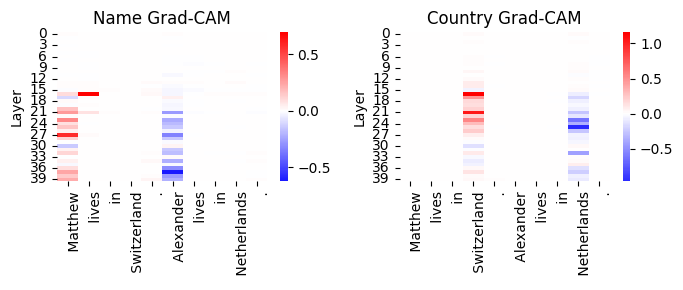

In [28]:
plot_name_attr('tulu')
plt.savefig('figures/tulu_probe_gradcam.pdf', bbox_inches="tight")

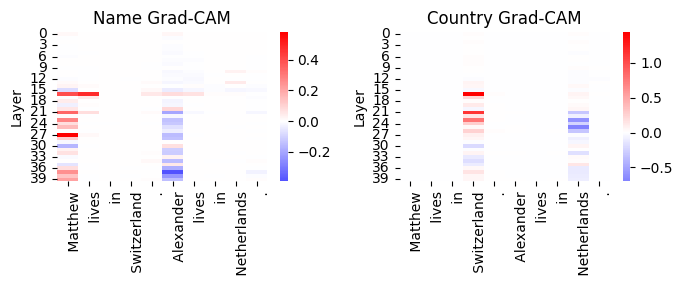

In [30]:
plot_name_attr('llama')
plt.savefig('figures/llama_probe_gradcam.pdf', bbox_inches="tight")

In [180]:
def get_metrics(dataset, model, use_class_conditioned):
    output_dir = get_probe_output_dir(dataset, model, use_class_conditioned)
    rows = []
    for probe in ['name_probe', 'food_probe', 'country_probe', 'occupation_probe']:
        with open(output_dir / probe / 'metrics.json') as f:
            metrics = json.load(f)
            for layer, metric in enumerate(metrics):
                rows.append({
                    **metric,
                    'layer': layer,
                    'dataset': dataset,
                    'model': model,
                    'use_class_conditioned': use_class_conditioned,
                    'probe': probe
                })
    return rows

In [181]:
rows = []
for model in ['llama', 'tulu']:
    for use_class_conditioned in [False, True]:
        for dataset in ['basic', 'paraphrase', 'paraphrase_es']:
            rows.extend(get_metrics(dataset, model, use_class_conditioned))
df = pd.DataFrame(rows)
df

,auroc,auprc,margin,soft_margin,hard_threshold,soft_threshold,threshold_acc,soft_threshold_acc,layer,dataset,model,use_class_conditioned,probe
0,1.000000,1.000000,0.666016,0.946289,0.690430,0.722168,1.000000,1.000000,0,basic,llama,False,name_probe
1,1.000000,1.000000,0.218750,0.820312,2.421875,2.261719,1.000000,1.000000,1,basic,llama,False,name_probe
2,1.000000,1.000000,0.437500,1.203125,3.812500,3.679688,1.000000,1.000000,2,basic,llama,False,name_probe
3,1.000000,1.000000,0.593750,1.562500,4.765625,4.562500,1.000000,1.000000,3,basic,llama,False,name_probe
4,1.000000,1.000000,0.531250,1.875000,5.546875,5.406250,1.000000,1.000000,4,basic,llama,False,name_probe
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,0.974432,0.939654,-24.468750,5.093750,14.015625,9.953125,0.273438,0.646484,35,paraphrase_es,tulu,True,occupation_probe
1916,0.975116,0.937658,-23.765625,4.859375,13.992188,9.679688,0.214844,0.609375,36,paraphrase_es,tulu,True,occupation_probe
1917,0.970721,0.925462,-22.531250,4.281250,13.484375,9.484375,0.222656,0.531250,37,paraphrase_es,tulu,True,occupation_probe
1918,0.964478,0.899525,-21.500000,3.687500,13.125000,9.406250,0.203125,0.458984,38,paraphrase_es,tulu,True,occupation_probe


In [245]:
def plot_probe(df, model, probe_name, ax, show_legend):
    df = df[(df.model == model) & (df.probe == probe_name)]
    
    df = df.assign(dataset=df.dataset.map(lambda x: {
        'basic': 'SYNTH',
        'paraphrase': 'PARA',
        'paraphrase_es': 'TRANS'
    }[x]))
    df = df.rename(columns={'auprc': 'AUC-PRC', 'layer': 'Layer', 'use_class_conditioned': 'Class Conditioned', 'dataset': 'Dataset'})

    sns.lineplot(
        df,
        x='Layer',
        y='AUC-PRC',
        hue='Dataset',
        style='Class Conditioned',
        ax=ax,
        style_order=[True, False]
    )
    if not show_legend:
        ax.get_legend().remove()
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 1], [0, 1])
    ax.set_xticks([0, 20, 40])
    

In [246]:
def plot_all_probes(model):
    fig, axs = plt.subplots(2, 2, figsize=(6, 4))
    plot_probe(df, model, 'name_probe', axs[0, 0], False)
    axs[0, 0].set_title('Name')
    plot_probe(df, model, 'country_probe', axs[0, 1], True)
    axs[0, 1].set_title('Country')
    plot_probe(df, model, 'food_probe', axs[1, 0], False)
    axs[1, 0].set_title('Food')
    plot_probe(df, model, 'occupation_probe', axs[1, 1], False)
    axs[1, 1].set_title('Occupation')
    
    axs[0,1].legend(loc='upper left', bbox_to_anchor=(1.01, 1.))
    
    fig.tight_layout()

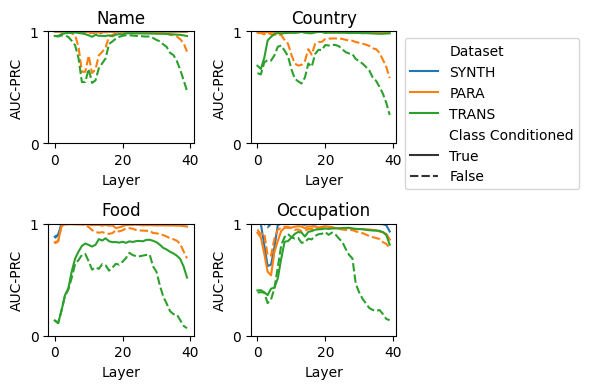

In [247]:
plot_all_probes('tulu')
plt.savefig('figures/tulu_layer_auprc.pdf', bbox_inches="tight")

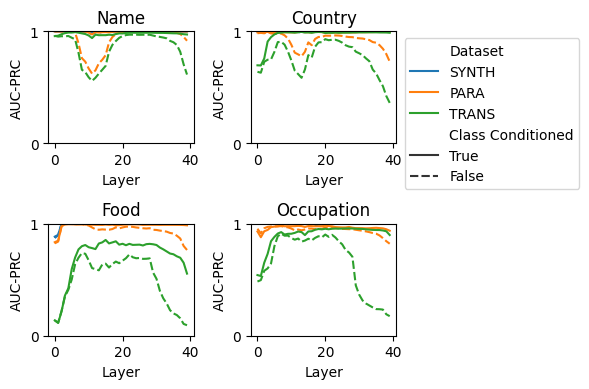

In [249]:
plot_all_probes('llama')
plt.savefig('figures/llama_layer_auprc.pdf', bbox_inches="tight")

## Determine probe threshold

In [252]:
model = 'llama'
accuracy_files = {
    'llama': '/scratch7/users/fjiahai/coref_exports/name_country_food_occupation_basic/llama/accuracies.csv',
    'tulu': '/scratch7/users/fjiahai/coref_exports/name_country_food_occupation_basic/tulu/accuracies.csv'
}

In [253]:
def plot_accuracies_for_model(model):
    accuracies = pd.read_csv(accuracy_files[model], index_col=0)

    fig, axes = plt.subplots(2,2)
    for ax, probe_name in zip(axes.flatten(), ['name_probe', 'country_probe', 'food_probe', 'occupation_probe']):
        cdf = accuracies[accuracies['probe_name'] == probe_name]
        sns.lineplot(cdf, ax=ax, x='threshold', y='accuracy', hue='dataset')
        ax.set_title(probe_name)

    axes[0,0].get_legend().remove()
    axes[1,0].get_legend().remove()
    axes[1,1].get_legend().remove()
    legend = axes[0,1].get_legend()
    legend.set(loc='upper right', title='Dataset')
    legend.get_texts()[0].set_text('SYNTH')
    legend.get_texts()[1].set_text('PARA')
    legend.get_texts()[2].set_text('TRANS')

    axes[0, 0].set_xlabel('')
    axes[0, 0].set_xticklabels([])
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_xticklabels([])
    axes[0, 1].set_ylabel('')
    axes[1, 1].set_ylabel('')

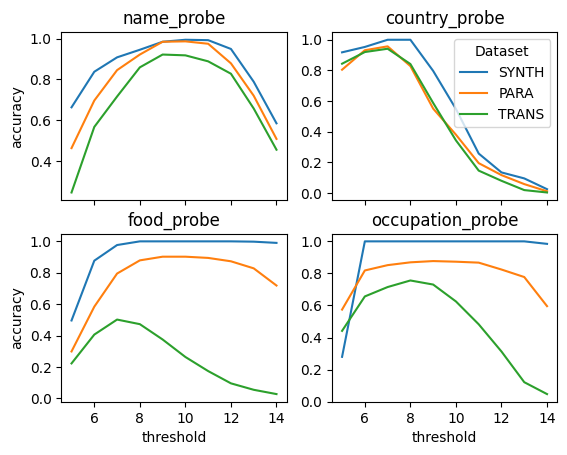

In [256]:
plot_accuracies_for_model('llama')
plt.savefig('figures/llama_domain_threshold_sweep.pdf', bbox_inches="tight")

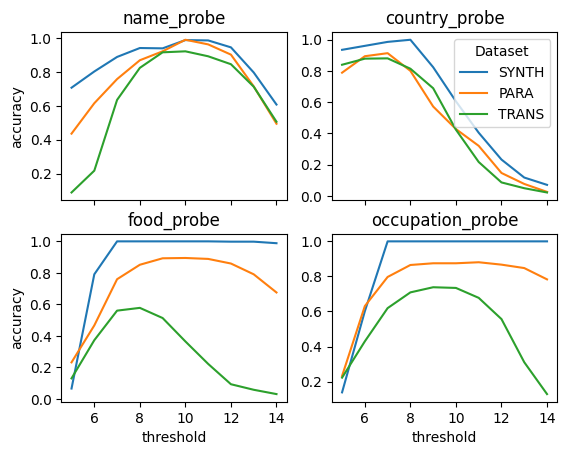

In [257]:
plot_accuracies_for_model('tulu')
plt.savefig('figures/tulu_domain_threshold_sweep.pdf', bbox_inches="tight")

## Evaluate domain probes

In [32]:
def get_eval_probe_output_dir(dataset, model, use_class_conditioned):
    cfg_path = expts_root / f'probes/eval_domain/{dataset}_{model}_use_class_{use_class_conditioned}.yaml'
    output_dir = get_last_output(cfg_path)
    return output_dir

In [33]:
def get_eval_metrics(dataset, model, use_class_conditioned):
    output_dir = get_eval_probe_output_dir(dataset, model, use_class_conditioned)
    rows = []
    for probe in ['name_probe', 'food_probe', 'country_probe', 'occupation_probe']:
        with open(output_dir / probe / 'metrics.json') as f:
            metrics = json.load(f)
            rows.append({
                **metrics,
                'dataset': dataset,
                'model': model,
                'use_class_conditioned': use_class_conditioned,
                'probe': probe
            })
    return rows
all_metrics = []
for use_class_conditioned in [True, False]:
    for model in ['tulu', 'llama']:
        for dataset in ['basic', 'paraphrase', 'paraphrase_es']:
            all_metrics.extend(get_eval_metrics(dataset, model, use_class_conditioned))

In [34]:
def explode_df_acc(df, acc_name, num_samples):
    gg = []
    for row in df.to_dict(orient='records'):
        for i in range(num_samples):
            if i / num_samples > row[acc_name]:
                gg.append({**row, acc_name: 0.})
            else:
                gg.append({**row, acc_name: 1.})
    return pd.DataFrame(gg)
        

In [35]:
def plot_eval_domain(model):
    df = pd.DataFrame(all_metrics)
    df = df[(df.model == model) & (df.use_class_conditioned==True)]
    
    df = df.assign(dataset=df.dataset.map(lambda x: {
        'basic': 'SYNTH',
        'paraphrase': 'PARA',
        'paraphrase_es': 'TRANS'
    }[x]))
    df = df.assign(probe=df.probe.map(lambda x: {
        'name_probe': 'Name',
        'country_probe': 'Country',
        'food_probe': 'Food',
        'occupation_probe': 'Occup.'
    }[x]))
    df = df.rename(columns={'acc': 'Accuracy',  'dataset': 'Dataset', 'probe': 'Domain'})
    
    df = explode_df_acc(df, 'Accuracy', 512)

    
    fig = plt.figure(figsize=(3.1, 2))
    ax = fig.add_subplot()
    sns.barplot(df, x='Domain', y='Accuracy', hue='Dataset', ax=ax, errorbar='se')
    ax.legend(loc="lower right")
    fig.tight_layout()
    
    return df

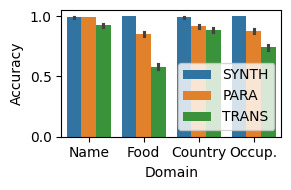

In [36]:
tulu_domain_res = plot_eval_domain('tulu')
plt.savefig('figures/tulu_eval_domain_probe.pdf', bbox_inches="tight")

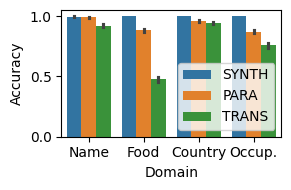

In [145]:
plot_eval_domain('llama')
plt.savefig('figures/llama_eval_domain_probe.pdf', bbox_inches="tight")

# Proposition Probes

In [7]:
import coref.probes.lookup_probe as lkp

In [8]:
def compute_IOU(preds, true_preds):
    preds = {lkp.list_to_tuple(p) for p in preds}
    true_preds = {lkp.list_to_tuple(p) for p in true_preds}
    I = len(preds & true_preds)
    U = len(preds | true_preds)
    return I / U

In [ ]:
def get_last_output(cfg_path):
    parent_dir = Path(rm.get_run_dir_parent(cfg_path, outputs_root, expts_root))
    dirs = [d for d in os.listdir(parent_dir)  if os.path.isdir(parent_dir / d)]
    success_dir = [d for d in dirs if 'done.out' in os.listdir(parent_dir / d)]
    max_run = max(int(d) for d in dirs)
    max_success = max(int(d) for d in success_dir)
    if max_run != max_success:
        print(f'Warning: latest run {max_run} of {cfg_path} is not successful. Falling back to {max_success}')
    return parent_dir / str(max_success)

In [ ]:
all_metrics = []
for model in ['tulu', 'llama']:
    for dataset in ['basic', 'paraphrase', 'paraphrase_es']:
        for probe_type in ['lookup', 'prompt']:
            if probe_type == 'lookup':
                test_path = expts_root / f'probes/eval/{dataset}_{probe_type}_{model}_hessian.yaml'
            else:
                test_path = expts_root / f'probes/eval/{dataset}_{probe_type}_{model}.yaml'
                
            with open(get_last_output(test_path) / 'metrics.json') as f:
                metrics = json.load(f)

            with open(get_last_output(test_path) / 'details.json') as f:
                details = json.load(f)
            IOUs= [
                compute_IOU(preds, true_preds)
                for preds, true_preds in zip(details['all_predicates'], details['all_true_predicates'])
            ]
            
            for iou in IOUs:
                all_metrics.append({
                    'Metric': 'IOU',
                    'value': iou,
                    'dataset': dataset,
                    'probe_type': probe_type,
                    'model': model
                })
            num_samples = 512
            for i in range(num_samples):
                if i/num_samples < metrics['acc']:
                    all_metrics.append({
                        'Metric': 'acc',
                        'value': 1.,
                        'dataset': dataset,
                        'probe_type': probe_type,
                        'model': model
                    })
                else:
                    all_metrics.append({
                        'Metric': 'acc',
                        'value': 0.,
                        'dataset': dataset,
                        'probe_type': probe_type,
                        'model': model
                    })

In [42]:
def plot_prop_eval(model):
    df = pd.DataFrame(all_metrics)
    df = df[df.model == model]
    # df = df.melt(id_vars=['dataset', 'probe_type', 'model'], var_name='Metric', value_name='value')
    df = df.assign(dataset=df.dataset.map(lambda x: {
        'basic': 'SYNTH',
        'paraphrase': 'PARA',
        'paraphrase_es': 'TRANS'
    }[x]))
    df = df.assign(probe_type=df.probe_type.map(lambda x: {
        'lookup': 'Prop. Probes',
        'prompt': 'Prompting'
    }[x]))
    
    df = df.assign(
        Metric=df.Metric.map(lambda x: {
            'IOU': 'Jaccard',
            'acc': 'EM Acc'
        }[x])
    )
    facet_grid = sns.catplot(df, x='dataset', hue='probe_type', y='value', col='Metric', kind='bar', height=2.3, aspect=.9, col_order=['Jaccard', 'EM Acc'], legend=False)
    
    for ax in facet_grid.axes.flatten():
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
    return df

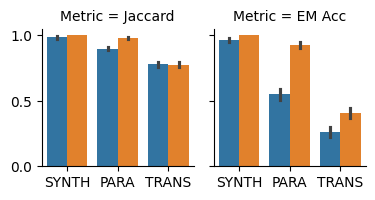

In [43]:
tulu_prop_res = plot_prop_eval('tulu')
plt.savefig('figures/tulu_eval_prop_probe.pdf', bbox_inches="tight")

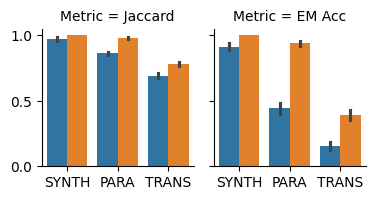

In [23]:
plot_prop_eval('llama')
plt.savefig('figures/llama_eval_prop_probe.pdf', bbox_inches="tight")

## Compare binding subspaces with DAS and random

In [46]:

all_metrics = []
for model in ['tulu', 'llama']:
    for dataset in ['basic', 'paraphrase', 'paraphrase_es']:
        for probe_type in ['lookup', 'prompt', 'das', 'das1', 'random']:
            if probe_type == 'lookup':
                test_path = expts_root / f'probes/eval/{dataset}_{probe_type}_{model}_hessian.yaml'
            elif probe_type == 'das':
                test_path = expts_root / f'probes/eval/{dataset}_lookup_{model}_das.yaml'
            elif probe_type == 'das1':
                test_path = expts_root / f'probes/eval/{dataset}_lookup_{model}_das1.yaml'
            elif probe_type == 'random':
                test_path = expts_root / f'probes/eval/{dataset}_lookup_{model}_random.yaml'
            else:
                test_path = expts_root / f'probes/eval/{dataset}_{probe_type}_{model}.yaml'
                
            with open(get_last_output(test_path) / 'metrics.json') as f:
                metrics = json.load(f)

            with open(get_last_output(test_path) / 'details.json') as f:
                details = json.load(f)
            IOUs= [
                compute_IOU(preds, true_preds)
                for preds, true_preds in zip(details['all_predicates'], details['all_true_predicates'])
            ]
            
            for iou in IOUs:
                all_metrics.append({
                    'Metric': 'IOU',
                    'value': iou,
                    'dataset': dataset,
                    'probe_type': probe_type,
                    'model': model
                })
            num_samples = 512
            for i in range(num_samples):
                if i/num_samples < metrics['acc']:
                    all_metrics.append({
                        'Metric': 'acc',
                        'value': 1.,
                        'dataset': dataset,
                        'probe_type': probe_type,
                        'model': model
                    })
                else:
                    all_metrics.append({
                        'Metric': 'acc',
                        'value': 0.,
                        'dataset': dataset,
                        'probe_type': probe_type,
                        'model': model
                    })

In [47]:
def plot_prop_eval(model):
    df = pd.DataFrame(all_metrics)
    df = df[df.model == model]
    # df = df.melt(id_vars=['dataset', 'probe_type', 'model'], var_name='Metric', value_name='value')
    df = df.assign(dataset=df.dataset.map(lambda x: {
        'basic': 'SYNTH',
        'paraphrase': 'PARA',
        'paraphrase_es': 'TRANS'
    }[x]))
    df = df.assign(probe_type=df.probe_type.map(lambda x: {
        'lookup': 'Prop. Probes',
        'prompt': 'Prompting',
        'das': 'Prop. Probes (DAS-50)',
        'das1': 'Prop. Probes (DAS-1)',
        'random': 'Prop. Probes (random)'
    }[x]))
    
    df = df.assign(
        Metric=df.Metric.map(lambda x: {
            'IOU': 'Jaccard',
            'acc': 'EM Acc'
        }[x])
    )
    df = df.rename(columns={'probe_type': 'Method'})
    facet_grid = sns.catplot(df, x='dataset', hue='Method', y='value', col='Metric', kind='bar', height=1.8, aspect=1., col_order=['Jaccard', 'EM Acc'], legend='auto', legend_out=False)
    for ax in facet_grid.axes.flatten():
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
    sns.move_legend(facet_grid, loc='center left', bbox_to_anchor=(-0.6, 0.5))
    facet_grid.tight_layout()
    # facet_grid.figure.tight_layout()
    return df

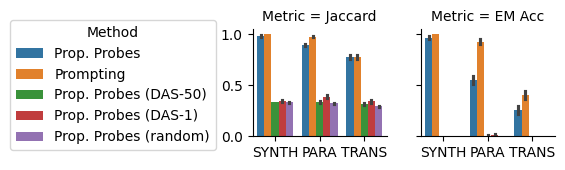

In [49]:
tulu_prop_res = plot_prop_eval('tulu')
plt.savefig('figures/tulu_eval_prop_probe_baselines.pdf', bbox_inches="tight")

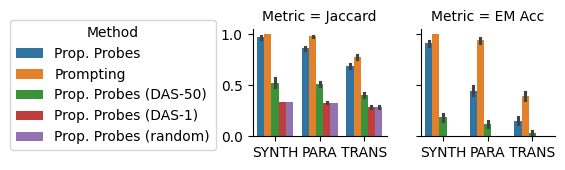

In [122]:
plot_prop_eval('llama')
plt.savefig('figures/llama_eval_prop_probe_baselines.pdf', bbox_inches="tight")

## Compare affinity

In [22]:
model = 'llama'


affinity_metrics = []
for affinity_fn in ['low_rank_inv', 'u_subspace_sq']:
    for dataset in ['basic', 'paraphrase', 'paraphrase_es']:
        for probe_type in ['lookup']:
            test_path = expts_root / f'probes/eval/{dataset}_{probe_type}_{model}_{affinity_fn}.yaml'
            with open(get_last_output(test_path) / 'metrics.json') as f:
                metrics = json.load(f)

            with open(get_last_output(test_path) / 'details.json') as f:
                details = json.load(f)

            mean_IOU = np.mean([
                compute_IOU(preds, true_preds)
                for preds, true_preds in zip(details['all_predicates'], details['all_true_predicates'])
            ])

            affinity_metrics.append({
                **metrics,
                'IOU': mean_IOU,
                'dataset': dataset,
                'affinity_fn': affinity_fn
            })
for dataset in ['basic', 'paraphrase', 'paraphrase_es']:
    for probe_type in ['lookup']:
        test_path = expts_root / f'probes/eval/{dataset}_{probe_type}_{model}.yaml'
        with open(get_last_output(test_path) / 'metrics.json') as f:
            metrics = json.load(f)
        
        with open(get_last_output(test_path) / 'details.json') as f:
            details = json.load(f)

        mean_IOU = np.mean([
            compute_IOU(preds, true_preds)
            for preds, true_preds in zip(details['all_predicates'], details['all_true_predicates'])
        ])
        
        affinity_metrics.append({
            **metrics,
            'IOU': mean_IOU,
            'dataset': dataset,
            'affinity_fn': 'low_rank'
        })

In [23]:
df = pd.DataFrame(affinity_metrics)
df

,acc,IOU,dataset,affinity_fn
0,0.000000,0.496807,basic,low_rank_inv
1,0.001953,0.518240,paraphrase,low_rank_inv
2,0.000000,0.460754,paraphrase_es,low_rank_inv
3,0.914062,0.973586,basic,u_subspace_sq
4,0.445312,0.862273,paraphrase,u_subspace_sq
5,0.152344,0.692018,paraphrase_es,u_subspace_sq
6,0.992188,0.994792,basic,low_rank
7,0.550781,0.887334,paraphrase,low_rank
8,0.224609,0.733370,paraphrase_es,low_rank


<Axes: xlabel='dataset', ylabel='IOU'>

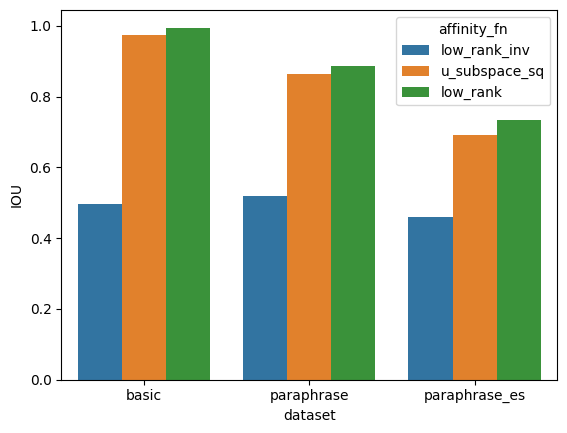

In [24]:
sns.barplot(df, x='dataset', hue='affinity_fn', y='IOU')

## Untruthful LMs

In [51]:
def get_metric_for(base_model):
    assert base_model in ['llama', 'tulu']
    model = base_model + '_ft'
    finetune_cfgs = [
        ('paraphrase_es', 'lookup', model, 'TRANS\n(ft)'),
        ('paraphrase_es', 'prompt', model, 'TRANS\n(ft)'),
    ]
    all_metrics = []

    model = base_model
    instruct_cfgs = [
        ('basic', 'lookup', model, 'SYNTH\n(p)'),
        ('basic', 'prompt', model, 'SYNTH\n(p)'),
        ('paraphrase', 'lookup', model, 'PARA\n(p)'),
        ('paraphrase', 'prompt', model, 'PARA\n(p)'),
        ('paraphrase_es', 'lookup', model, 'TRANS\n(p)'),
        ('paraphrase_es', 'prompt', model, 'TRANS\n(p)'),
    ]
    for dataset, probe_type, model, name in instruct_cfgs:
        test_path = expts_root / f'probes/eval/{dataset}_{probe_type}_{model}_prefix_opp2.yaml'
        with open(get_last_output(test_path) / 'metrics.json') as f:
            metrics = json.load(f)

        with open(get_last_output(test_path) / 'details.json') as f:
            details = json.load(f)

        IOUs= [
            compute_IOU(preds, true_preds)
            for preds, true_preds in zip(details['all_predicates'], details['all_true_predicates'])
        ]


        for iou in IOUs:
            all_metrics.append({
                'Metric': 'IOU',
                'value': iou,
                'dataset': dataset,
                'probe_type': probe_type,
                'name': name
            })
        num_samples = 512
        for i in range(num_samples):
            if i/num_samples < metrics['acc']:
                all_metrics.append({
                    'Metric': 'acc',
                    'value': 1.,
                    'dataset': dataset,
                    'probe_type': probe_type,
                    'name': name
                })
            else:
                all_metrics.append({
                    'Metric': 'acc',
                    'value': 0.,
                    'dataset': dataset,
                    'probe_type': probe_type,
                    'name': name
                })


    for dataset, probe_type, model, name in finetune_cfgs:
        test_path = expts_root / f'probes/eval/{dataset}_{probe_type}_{model}.yaml'
        with open(get_last_output(test_path) / 'metrics.json') as f:
            metrics = json.load(f)

        with open(get_last_output(test_path) / 'details.json') as f:
            details = json.load(f)

        IOUs= [
            compute_IOU(preds, true_preds)
            for preds, true_preds in zip(details['all_predicates'], details['all_true_predicates'])
        ]

        for iou in IOUs:
            all_metrics.append({
                'Metric': 'IOU',
                'value': iou,
                'dataset': dataset,
                'probe_type': probe_type,
                'name': name
            })
        num_samples = 512
        for i in range(num_samples):
            if i/num_samples < metrics['acc']:
                all_metrics.append({
                    'Metric': 'acc',
                    'value': 1.,
                    'dataset': dataset,
                    'probe_type': probe_type,
                    'name': name
                })
            else:
                all_metrics.append({
                    'Metric': 'acc',
                    'value': 0.,
                    'dataset': dataset,
                    'probe_type': probe_type,
                    'name': name
                })
    return all_metrics

In [53]:
def plot_untruthful(all_metrics):
    df = pd.DataFrame(all_metrics)
    df = df.assign(dataset=df.dataset.map(lambda x: {
        'basic': 'SYNTH',
        'paraphrase': 'PARA',
        'paraphrase_es': 'TRANS'
    }[x]))
    df = df.assign(probe_type=df.probe_type.map(lambda x: {
        'lookup': 'Prop. Probes',
        'prompt': 'Prompting'
    }[x]))
    
    df = df.assign(
        Metric=df.Metric.map(lambda x: {
            'IOU': 'Jaccard',
            'acc': 'EM Acc'
        }[x])
    )
    
    df = df.rename(columns={'name': 'Condition', 'probe_type': 'Method'})
    
    facet_grid = sns.catplot(df, x='Condition', hue='Method', y='value', col='Metric', kind='bar', height=2.2, aspect=1.1, col_order=['Jaccard', 'EM Acc'], legend=False)
    
    # facet_grid.tick_params(labelrotation=45)
    for ax in facet_grid.axes.flatten():
        # plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
        #  rotation_mode="anchor")
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
    return df

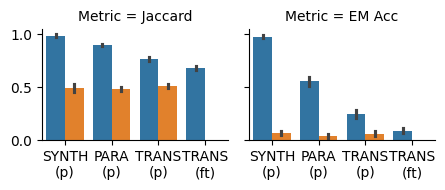

In [54]:
all_metrics = get_metric_for('tulu')
tulu_untruthful_res = plot_untruthful(all_metrics)
plt.savefig('figures/tulu_untruthful.pdf', bbox_inches="tight")

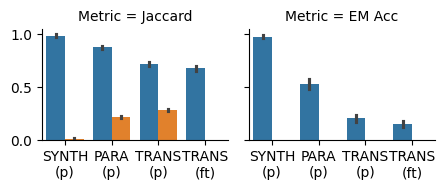

In [125]:
all_metrics = get_metric_for('llama')
plot_untruthful(all_metrics)
plt.savefig('figures/llama_untruthful.pdf', bbox_inches="tight")

## Tabular version

In [55]:
tulu_domain_res

,auroc,auprc,margin,soft_margin,hard_threshold,soft_threshold,threshold_acc,soft_threshold_acc,Accuracy,Dataset,model,use_class_conditioned,Domain
0,0.999993,0.999793,-2.156250,10.796875,8.921875,8.914062,0.939453,0.939453,1.0,SYNTH,tulu,True,Name
1,0.999993,0.999793,-2.156250,10.796875,8.921875,8.914062,0.939453,0.939453,1.0,SYNTH,tulu,True,Name
2,0.999993,0.999793,-2.156250,10.796875,8.921875,8.914062,0.939453,0.939453,1.0,SYNTH,tulu,True,Name
3,0.999993,0.999793,-2.156250,10.796875,8.921875,8.914062,0.939453,0.939453,1.0,SYNTH,tulu,True,Name
4,0.999993,0.999793,-2.156250,10.796875,8.921875,8.914062,0.939453,0.939453,1.0,SYNTH,tulu,True,Name
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,0.976028,0.958571,-13.890625,6.718750,7.929688,8.640625,0.708984,0.734375,0.0,TRANS,tulu,True,Occup.
6140,0.976028,0.958571,-13.890625,6.718750,7.929688,8.640625,0.708984,0.734375,0.0,TRANS,tulu,True,Occup.
6141,0.976028,0.958571,-13.890625,6.718750,7.929688,8.640625,0.708984,0.734375,0.0,TRANS,tulu,True,Occup.
6142,0.976028,0.958571,-13.890625,6.718750,7.929688,8.640625,0.708984,0.734375,0.0,TRANS,tulu,True,Occup.


In [56]:
tulu_prop_res

,Metric,value,dataset,Method,model
0,Jaccard,1.000000,SYNTH,Prop. Probes,tulu
1,Jaccard,1.000000,SYNTH,Prop. Probes,tulu
2,Jaccard,1.000000,SYNTH,Prop. Probes,tulu
3,Jaccard,1.000000,SYNTH,Prop. Probes,tulu
4,Jaccard,0.857143,SYNTH,Prop. Probes,tulu
...,...,...,...,...,...
13435,EM Acc,0.000000,TRANS,Prop. Probes (random),tulu
13436,EM Acc,0.000000,TRANS,Prop. Probes (random),tulu
13437,EM Acc,0.000000,TRANS,Prop. Probes (random),tulu
13438,EM Acc,0.000000,TRANS,Prop. Probes (random),tulu


In [68]:
tulu_prop_means = tulu_prop_res.groupby(['Method', 'model', 'dataset', 'Metric']).mean()
tulu_prop_sems = tulu_prop_res.groupby(['Method', 'model', 'dataset', 'Metric']).sem()

In [57]:
tulu_untruthful_res

,Metric,value,dataset,Method,Condition
0,Jaccard,1.0,SYNTH,Prop. Probes,SYNTH\n(p)
1,Jaccard,1.0,SYNTH,Prop. Probes,SYNTH\n(p)
2,Jaccard,1.0,SYNTH,Prop. Probes,SYNTH\n(p)
3,Jaccard,1.0,SYNTH,Prop. Probes,SYNTH\n(p)
4,Jaccard,1.0,SYNTH,Prop. Probes,SYNTH\n(p)
...,...,...,...,...,...
7419,EM Acc,0.0,TRANS,Prompting,TRANS\n(ft)
7420,EM Acc,0.0,TRANS,Prompting,TRANS\n(ft)
7421,EM Acc,0.0,TRANS,Prompting,TRANS\n(ft)
7422,EM Acc,0.0,TRANS,Prompting,TRANS\n(ft)


In [70]:
tulu_untruthful_means = tulu_untruthful_res.drop(columns=['dataset']).groupby(['Method', 'Condition', 'Metric']).mean()
tulu_untruthful_sems = tulu_untruthful_res.drop(columns=['dataset']).groupby(['Method', 'Condition', 'Metric']).sem()

In [138]:
datasets = ['SYNTH','PARA', 'TRANS']
metrics = ['EM Acc', 'Jaccard']
untruthful_conditions = ['SYNTH\n(p)', 'PARA\n(p)', 'TRANS\n(p)', 'TRANS\n(ft)']
methods = ['Prompting', 'Prop. Probes']
tulu_prop_data = [
    [
        [
            (
                tulu_prop_means.loc[(method, "tulu", dataset, metric)].value,
                tulu_prop_sems.loc[(method, "tulu", dataset, metric)].value
            )
            for dataset in datasets
        ] + [
            (
                tulu_untruthful_means.loc[(method, condition, metric)].value,
                tulu_untruthful_sems.loc[(method, condition, metric)].value
            )
            for condition in untruthful_conditions
        ]
        for metric in metrics
    ]
    for method in methods
]

In [139]:
import xarray as xr

In [140]:
da = xr.DataArray(tulu_prop_data, coords=[('method', methods), ('metric', metrics), ('dataset', datasets + untruthful_conditions), ('stat', ['mean', 'sem'])])

In [141]:
is_max = da.sel(stat='mean') == da.sel(stat='mean').max('method')

In [142]:

tulu_prop_formatted = xr.apply_ufunc(
    lambda bold, mean, sem: (
        '{:.2f} ({:.2f})'
        if not bold
        else '\\textbf{{ {:.2f} }} ({:.2f}) '
    ).format(mean, sem),
    is_max,
    da.sel(stat='mean'),
    da.sel(stat='sem'),
    # input_core_dims=[['method', 'metrics', 'dataset']]*3
    vectorize=True
)

In [143]:
table_template = r'''
\begin{tabular}{l@{\hspace{3pt}}lccccccc}
\toprule
& & \multicolumn{3}{c}{Standard setting} & \multicolumn{4}{c}{Unfaithful setting} \\
\cmidrule(lr){3-5} \cmidrule(lr){6-9}
Method & Metric & \textsc{synth} & \textsc{para} & \textsc{trans} & \textsc{synth} (P) & \textsc{para} (P) & \textsc{trans} (P) & \textsc{trans} (FT)\\
\midrule
\textbf{Prompting}      & EM      & {{ ' & '.join(tulu_prop_formatted.sel(dict(method='Prompting', metric='EM Acc')).to_numpy()) }} \\
                        & Jaccard & {{ ' & '.join(tulu_prop_formatted.sel(dict(method='Prompting', metric='Jaccard')).to_numpy()) }} \\
\midrule
\textbf{Prop. Probes}   & EM      & {{ ' & '.join(tulu_prop_formatted.sel(dict(method='Prop. Probes', metric='EM Acc')).to_numpy()) }} \\
                        & Jaccard & {{ ' & '.join(tulu_prop_formatted.sel(dict(method='Prop. Probes', metric='Jaccard')).to_numpy()) }} \\
\bottomrule
\end{tabular}
'''

In [144]:
from jinja2 import Template

In [145]:
print(Template(table_template).render(tulu_prop_formatted=tulu_prop_formatted))


\begin{tabular}{l@{\hspace{3pt}}lccccccc}
\toprule
& & \multicolumn{3}{c}{Standard setting} & \multicolumn{4}{c}{Unfaithful setting} \\
\cmidrule(lr){3-5} \cmidrule(lr){6-9}
Method & Metric & \textsc{synth} & \textsc{para} & \textsc{trans} & \textsc{synth} (P) & \textsc{para} (P) & \textsc{trans} (P) & \textsc{trans} (FT)\\
\midrule
\textbf{Prompting}      & EM      & \textbf{ 1.00 } (0.00)  & \textbf{ 0.93 } (0.01)  & \textbf{ 0.40 } (0.02)  & 0.07 (0.01) & 0.04 (0.01) & 0.06 (0.01) & 0.00 (0.00) \\
                        & Jaccard & \textbf{ 1.00 } (0.00)  & \textbf{ 0.98 } (0.00)  & 0.78 (0.01) & 0.49 (0.02) & 0.48 (0.01) & 0.51 (0.01) & 0.00 (0.00) \\
\midrule
\textbf{Prop. Probes}   & EM      & 0.97 (0.01) & 0.55 (0.02) & 0.26 (0.02) & \textbf{ 0.98 } (0.01)  & \textbf{ 0.55 } (0.02)  & \textbf{ 0.24 } (0.02)  & \textbf{ 0.09 } (0.01)  \\
                        & Jaccard & 0.99 (0.01) & 0.90 (0.01) & \textbf{ 0.78 } (0.01)  & \textbf{ 0.99 } (0.01)  & \textbf{ 0.90 } (0.01)  & 

In [146]:
methods = ['Prop. Probes', 'Prop. Probes (DAS-1)', 'Prop. Probes (DAS-50)', 'Prop. Probes (random)']
datasets = ['SYNTH','PARA', 'TRANS']
metrics = ['EM Acc', 'Jaccard']
tulu_ablate_data = [
    [
        [
            (
                tulu_prop_means.loc[(method, "tulu", dataset, metric)].value,
                tulu_prop_sems.loc[(method, "tulu", dataset, metric)].value
            )
            for dataset in datasets
        ] 
        for metric in metrics
    ]
    for method in methods
]
da = xr.DataArray(tulu_ablate_data, coords=[('method', methods), ('metric', metrics), ('dataset', datasets), ('stat', ['mean', 'sem'])])

In [147]:
tulu_ablate_formatted = xr.apply_ufunc(
    lambda mean, sem: (
        '{:.2f} ({:.2f})'
    ).format(mean, sem),
    da.sel(stat='mean'),
    da.sel(stat='sem'),
    vectorize=True
)

In [155]:
tulu_filtered_domain_res = tulu_domain_res[['Accuracy', 'use_class_conditioned', 'Domain', 'Dataset']].pipe(
    lambda x: x[x['use_class_conditioned']].drop(columns=['use_class_conditioned'])
)
tulu_domain_means = tulu_filtered_domain_res.groupby(['Domain', 'Dataset']).mean()
tulu_domain_sems = tulu_filtered_domain_res.groupby(['Domain', 'Dataset']).sem()

In [162]:
tulu_domain_da = xr.concat(
    [
        xr.DataArray.from_series(tulu_domain_means.Accuracy), 
        xr.DataArray.from_series(tulu_domain_sems.Accuracy)
    ], 
    pd.Index(['mean', 'sem'], name='stat')
)

In [170]:
domains = ['Name', 'Food', 'Country', 'Occup.']
tulu_domain_formatted = xr.apply_ufunc(
    lambda mean, sem: (
        '{:.2f} ({:.2f})'
    ).format(mean, sem),
    tulu_domain_da.sel(stat='mean'),
    tulu_domain_da.sel(stat='sem'),
    vectorize=True
).sel(Domain=domains)

In [174]:
ablations_table_template = r'''
\begin{tabular}{l@{\hspace{3pt}}lcccccccc}
\toprule
& & \multicolumn{4}{c}{Prop. Probe Ablations} & \multicolumn{4}{c}{Domain Probes} \\
\cmidrule(lr){3-6} \cmidrule(lr){7-10}
Dataset & Metric & Hessian & DAS-50 & DAS-1 & random & Names & Food & Countries & Occ.\\
\midrule
\textsc{synth}  & EM      &  {{ ' & '.join(tulu_ablate_formatted.sel(dict(dataset='SYNTH', metric='EM Acc')).to_numpy()) }}
                            & {{' & '.join(tulu_domain_formatted.sel(dict(Dataset='SYNTH')).to_numpy()) }} \\
                & Jaccard & {{ ' & '.join(tulu_ablate_formatted.sel(dict(dataset='SYNTH', metric='Jaccard')).to_numpy()) }}
                            & {{ ' & '.join(['-']*4) }} \\
\midrule
\textsc{para }  & EM      &  {{ ' & '.join(tulu_ablate_formatted.sel(dict(dataset='PARA', metric='EM Acc')).to_numpy()) }}
                            & {{' & '.join(tulu_domain_formatted.sel(dict(Dataset='PARA')).to_numpy()) }} \\
                & Jaccard & {{ ' & '.join(tulu_ablate_formatted.sel(dict(dataset='PARA', metric='Jaccard')).to_numpy()) }}
                            & {{ ' & '.join(['-']*4) }} \\
\midrule
\textsc{trans}  & EM      &  {{ ' & '.join(tulu_ablate_formatted.sel(dict(dataset='TRANS', metric='EM Acc')).to_numpy()) }}
                            & {{' & '.join(tulu_domain_formatted.sel(dict(Dataset='TRANS')).to_numpy()) }} \\
                & Jaccard & {{ ' & '.join(tulu_ablate_formatted.sel(dict(dataset='TRANS', metric='Jaccard')).to_numpy()) }}
                            & {{ ' & '.join(['-']*4) }} \\
\bottomrule
\end{tabular}
'''

In [175]:
print(Template(ablations_table_template).render(tulu_ablate_formatted=tulu_ablate_formatted,tulu_domain_formatted=tulu_domain_formatted))


\begin{tabular}{l@{\hspace{3pt}}lcccccccc}
\toprule
& & \multicolumn{4}{c}{Prop. Probe Ablations} & \multicolumn{4}{c}{Domain Probes} \\
\cmidrule(lr){3-6} \cmidrule(lr){7-10}
Dataset & Metric & Hessian & DAS-50 & DAS-1 & random & Names & Food & Countries & Occ.\\
\midrule
\textsc{synth}  & EM      &  0.97 (0.01) & 0.00 (0.00) & 0.00 (0.00) & 0.00 (0.00)
                            & 0.99 (0.00) & 1.00 (0.00) & 0.99 (0.00) & 1.00 (0.00) \\
                & Jaccard & 0.99 (0.01) & 0.35 (0.00) & 0.33 (0.00) & 0.33 (0.00)
                            & - & - & - & - \\
\midrule
\textsc{para }  & EM      &  0.55 (0.02) & 0.01 (0.00) & 0.00 (0.00) & 0.00 (0.00)
                            & 0.99 (0.00) & 0.85 (0.02) & 0.92 (0.01) & 0.88 (0.01) \\
                & Jaccard & 0.90 (0.01) & 0.39 (0.01) & 0.33 (0.00) & 0.32 (0.00)
                            & - & - & - & - \\
\midrule
\textsc{trans}  & EM      &  0.26 (0.02) & 0.00 (0.00) & 0.00 (0.00) & 0.00 (0.00)
                          

## Systematic Order Experiments

In [120]:
all_datasets=['series', 'cross', 'nested', 'medium', 'long', 'nested_2', 'coref', 'nested_wrong', 'nested_es']
def get_metrics_for(dim=None, datasets=all_datasets):
    rebuttal_metrics = []
    for model in ['tulu', 'llama']:
        for dataset in datasets:
            for probe_type in ['lookup', 'prompt', 'matched']:
                try:
                    if 'wrong' in dataset:
                        dataset_name, _ = dataset.split('_')
                        test_path = expts_root / f'probes/eval/{dataset_name}_{probe_type}_{model}_prefix_opp2.yaml'
                    elif '_es' in dataset:
                        test_path = expts_root / f'probes/eval/{dataset}_{probe_type}_{model}_ft_hessian.yaml'
                    elif dim is not None and probe_type != 'prompt':
                        test_path = expts_root / f'probes/eval/{dataset}_{probe_type}_{model}_hessian_{dim}.yaml'
                    else:
                        test_path = expts_root / f'probes/eval/{dataset}_{probe_type}_{model}_hessian.yaml'
                    
                    with open(get_last_output(test_path) / 'metrics.json') as f:
                        metrics = json.load(f)
        
                    with open(get_last_output(test_path) / 'details.json') as f:
                        details = json.load(f)
                except Exception as e:
                    print(f'error loading')
                    print(e)
                IOUs= [
                    compute_IOU(preds, true_preds)
                    for preds, true_preds in zip(details['all_predicates'], details['all_true_predicates'])
                ]
                
                for iou in IOUs:
                    rebuttal_metrics.append({
                        'Metric': 'IOU',
                        'value': iou,
                        'dataset': dataset,
                        'probe_type': probe_type,
                        'model': model
                    })
                num_samples = 512
                for i in range(num_samples):
                    if i/num_samples < metrics['acc']:
                        rebuttal_metrics.append({
                            'Metric': 'acc',
                            'value': 1.,
                            'dataset': dataset,
                            'probe_type': probe_type,
                            'model': model
                        })
                    else:
                        rebuttal_metrics.append({
                            'Metric': 'acc',
                            'value': 0.,
                            'dataset': dataset,
                            'probe_type': probe_type,
                            'model': model
                        })
    return rebuttal_metrics

In [139]:
def plot_rebuttal_eval(all_metrics, model, drop_matched=False, aspect=2, series_name='series'):
    df = pd.DataFrame(all_metrics)
    df = df[df.model == model]
    if drop_matched:
        df = df[df.probe_type != 'matched']
    # df = df.melt(id_vars=['dataset', 'probe_type', 'model'], var_name='Metric', value_name='value')
    df = df.assign(dataset=df.dataset.map(lambda x: {
        'series': series_name,
        'cross': 'cross',
        'nested': 'nested',
        'medium': 'medium',
        'long': 'long',
        'nested_2': 'nested_2',
        'coref': 'coref',
        'nested_wrong': 'nested (P)',
        'nested_es': 'nested (FT)',
        'reverse': 'reverse'
    }[x]))
    df = df.assign(probe_type=df.probe_type.map(lambda x: {
        'lookup': 'Prop. Probes',
        'prompt': 'Prompting',
        'matched': 'Prop. Probes (matched)'
    }[x]))
    
    df = df.assign(
        Metric=df.Metric.map(lambda x: {
            'IOU': 'Jaccard',
            'acc': 'EM Acc'
        }[x])
    )
    df = df.rename(columns={'probe_type': 'Probe Type'})
    facet_grid = sns.catplot(df, x='dataset', hue='Probe Type', y='value', col='Metric', kind='bar', height=2.3, aspect=aspect, col_order=['Jaccard', 'EM Acc'], legend=True)
    
    for ax in facet_grid.axes.flatten():
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
    return df

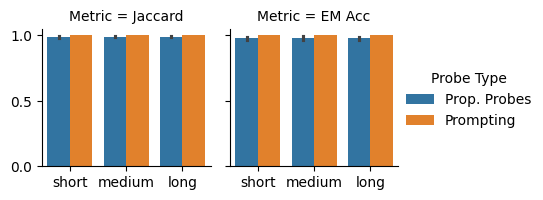

In [134]:
rebuttal_metrics = get_metrics_for(datasets=['series', 'medium', 'long'])
plot_rebuttal_eval(rebuttal_metrics, 'tulu', drop_matched=True, aspect=1, series_name='short');

plt.savefig('figures/tulu_length_gen.pdf', bbox_inches="tight")

In [ ]:
rebuttal_metrics = get_metrics_for(datasets=['series', 'cross', 'reverse', 'coref', 'nested'])
ds = plot_rebuttal_eval(rebuttal_metrics, 'tulu', drop_matched=True, aspect=1.5, series_name='short')

plt.savefig('figures/tulu_order_gen.pdf', bbox_inches="tight")

In [154]:
ds[(ds.dataset=='nested') & (ds.Metric=='EM Acc') & (ds['Probe Type'] == 'Prop. Probes')].value.mean()

0.443359375

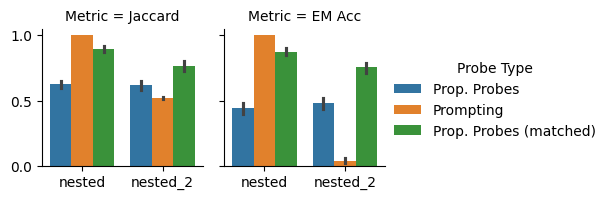

In [141]:
rebuttal_metrics = get_metrics_for(datasets=['nested', 'nested_2'])
plot_rebuttal_eval(rebuttal_metrics, 'tulu', drop_matched=False, aspect=1, series_name='short');

plt.savefig('figures/tulu_nested_lookup.pdf', bbox_inches="tight")

In [ ]:
rebuttal_metrics = get_metrics_for(datasets=['nested', 'nested_wrong', 'nested_es'])
plot_rebuttal_eval(rebuttal_metrics, 'tulu', drop_matched=True, aspect=1.4, series_name='short');

plt.savefig('figures/tulu_nested_adv.pdf', bbox_inches="tight")

In [ ]:
dataset = 'nested_2'
probe_type = 'lookup'
model = 'tulu'


test_path = expts_root / f'probes/eval/{dataset}_{probe_type}_{model}_hessian.yaml'
with open(get_last_output(test_path) / 'details.json') as f:
    details = json.load(f)

In [61]:
def compare_preds(p1, p2):
    for x, y in zip(p1, p2):
        if isinstance(x, list):
            if not compare_preds(x, y):
                return False
        elif x != y:
            return False
    return True

In [62]:
def tuplify(x):
    return tuple(
        i if not isinstance(i, list) else tuplify(i)
        for i in x
    )

In [63]:
correct_cnt, double_name_cnt, neither_cnt = 0, 0, 0
for idx in range(len(details['all_predicates'])):
    correct = set(tuplify(x) for x in details['all_predicates'][idx]) == set(tuplify(x) for x in details['all_true_predicates'][idx])
    double_name = details['all_predicates'][idx][0][0] == details['all_predicates'][idx][1][0]
    correct_cnt += correct
    double_name_cnt += double_name
    neither_cnt += (not correct) and (not double_name)

In [64]:
correct_cnt, double_name_cnt, neither_cnt

(246, 210, 56)

In [155]:
210/(512-246)

0.7894736842105263

In [ ]:
details['all_predicates']

## Gender bias

In [91]:
import torch

In [96]:
from coref.gender.synthetic import compute_metrics

In [92]:
all_metrics = []
for model in ['llama', 'tulu']:
    cfg_path = expts_root / f'genderbias/{model}.yaml'
    output_path = Path(get_last_output(cfg_path))
    with open(output_path/'metrics.json') as f:
        metrics = json.load(f)
    all_metrics.extend(
        attach_d(
            metrics,
            {'model': model}
        )
    )

In [94]:
def plot_genderbias(model):
    
    df = pd.DataFrame(all_metrics)
    df = df[df.model == model]
    df = df.melt(id_vars=['split', 'method', 'model'], var_name='Metric', value_name='value')
    df = df.assign(method=df.method.map(lambda x: {
        'external': 'Prompt',
        'internal': 'Probe',
    }[x]))
    
    df = df.assign(
        Metric=df.Metric.map(lambda x: {
            'accuracy': 'Acc.',
            'calibrated_accuracy': 'Calibrated Acc.'
        }[x])
    )
    # explode accuracy with 800, calibrated acc with 400
    new_rows = []
    num_samples_dict = {'Acc.': 800, 'Calibrated Acc.':400}
    for row in df.to_dict(orient='records'):
        for i in range(num_samples_dict[row['Metric']]):
            if i / num_samples_dict[row['Metric']] < row['value']:
                new_rows.append({**row, 'value':1})
            else:
                new_rows.append({**row, 'value':0})
    df = pd.DataFrame(new_rows)
    facet_grid = sns.catplot(df, x='split', hue='method', y='value', col='Metric', kind='bar', height=3, aspect=.8, col_order=['Acc.', 'Calibrated Acc.'])
    for ax in facet_grid.axes.flatten():
        # plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
        #  rotation_mode="anchor")
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

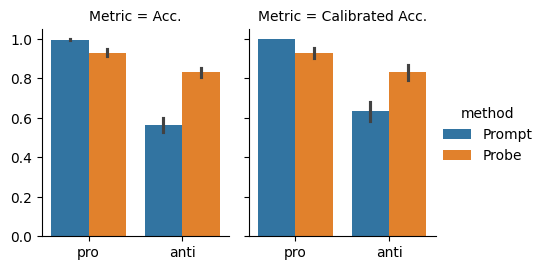

In [95]:
plot_genderbias('tulu')
plt.savefig('figures/tulu_gender.pdf', bbox_inches="tight")

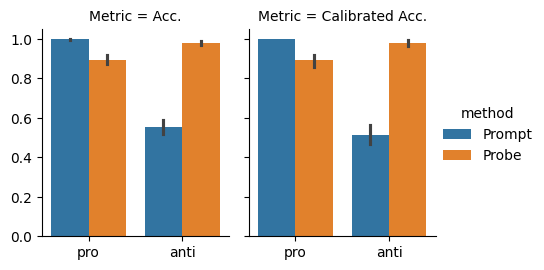

In [96]:
plot_genderbias('llama')
plt.savefig('figures/llama_gender.pdf', bbox_inches="tight")

### Breakdown by cis / trans

In [92]:
def get_gender_data(model):
    cfg_path = expts_root / f'genderbias/{model}.yaml'
    output_path = Path(get_last_output(cfg_path))
    data = torch.load(output_path / 'data.pt')
    return data
    

In [93]:
data = get_gender_data('tulu')

In [107]:
def take_first_half(data):
    new_data = {}
    for k in data:
        new_data[k] = {}
        for l in data[k]:
            new_data[k][l] = data[k][l][:, :200]
    return new_data
def take_second_half(data):
    new_data = {}
    for k in data:
        new_data[k] = {}
        for l in data[k]:
            new_data[k][l] = data[k][l][:, 200:]
    return new_data

In [108]:
cis_data = take_first_half(data)
trans_data = take_second_half(data)

In [158]:
from exults.tensorial import Long

In [159]:
cis_trans_metrics = []
for order_data, order_name in [
    (cis_data, 'series'),
    (trans_data, 'nested')
]:
    for method, res in [
        ('probe', order_data['internal_data']),
        ('prompt', order_data['external_data']),
    ]:
        cis_trans_metrics.extend(
            Long(compute_metrics(res)).attach(
                method=method,
                order=order_name
            ).data
        )

In [160]:
pd.DataFrame(cis_trans_metrics)

,split,accuracy,calibrated_accuracy,method,order
0,pro,1.0000,1.000,probe,series
1,anti,1.0000,1.000,probe,series
2,pro,1.0000,1.000,prompt,series
3,anti,0.5650,0.700,prompt,series
4,pro,0.8575,0.855,probe,nested
5,anti,0.6575,0.665,probe,nested
6,pro,0.9925,1.000,prompt,nested
7,anti,0.5550,0.570,prompt,nested


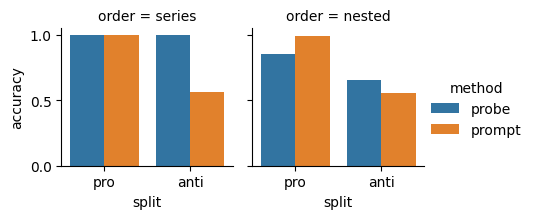

In [163]:
sns.catplot(pd.DataFrame(cis_trans_metrics), x='split', hue='method', y='accuracy', kind='bar', col='order', height=2.3, aspect=1)
plt.savefig('figures/tulu_gender_breakdown.pdf', bbox_inches="tight")